# Bayesian Treatment 

## Dichomtomous treatment and response

Finally, we get to what is perhaps the trickiest case - a situation in which we have treatment and response which are binary. In this case, we have to simulate latent variables to capture correlation across equations, and also the two unobserved latent variables dictating outcomes. 

One thing about this is that it leaves the whole situation with the covariance matrix a little uncertain. If I am doing things correctly, it seems we have to put the prior to work to identify the model. Anyways, here it goes!

The model now consists of a treatment equation which determines who winds up treated or not, according to the latent variable:

$$
z = W\eta + u_c + e_z, \quad z^*=1 \qquad \textrm{if} \qquad z>0
$$

If treated, we have an outcome dictated by

$$
y_1 = X\beta_1 + \pi_{1c}u_c + \pi_{1r}u_r+e_1, \quad y_1^*=1 \qquad \textrm{if} \qquad y>0
$$

and
$$
y_0 = X\beta_0 + \pi_{0c}u_c + \pi_{0r}u_r+e_0, \quad y_0^*=1 \qquad \textrm{if} \qquad y>0
$$

As before, we can compute the covariance matrix as follows:

$$
\Sigma=\left[
\begin{array}{ccc}
\pi_{1c}^2+\pi_{1r}^2+\sigma_1^2 & \pi_{1c}\pi_{0c}+\pi_{1r}\pi_{0r} & \pi_{1c} \\
 & \pi_{0c}^2+\pi_{0r}^2+\sigma_0^2 & \pi_{0c} \\
 & & 1 + \sigma_t^2
\end{array}
\right]
$$




Even after assuming all latent variables are standard normal, there are seven things to be determined in this matrix. In the very best of all worlds. The question becomes: in this discrete-discrete world, what can possibly be identified? 

Some thoughts:

1. In the typical probit, one makes a normalizing assumption: the variance on the latent variable is zero. Here, we have three variables like this (treatment, outcome when treated, outcome when not treated). So, it stands to reason that we have to normalize the variance on these terms (i. e., assume that $\sigma_1^2=1,\sigma_0^2=1,\sigma_t^2=1$ or something to that effect.

2. This now leads us, still, with four free parameters. This strikes me as too many for some ill-defined reason. But let's proceed and see what happens. 

In terms of drawing values, we really need only follow what we did before, but now with the added step of drawing the unobserved variables $y_1$ and $y_0$. We don't actually see these, but draw them from a truncated normal. So, here goes the usual startup stuff:

In [1]:
import ipystata

In [2]:
%%stata 
clear all
use http://www.stata-press.com/data/r13/union3
set more off
keep if union != . 
keep if tenure != .
set seed 42
describe


(National Longitudinal Survey.  Young Women 14-26 years of age in 1968)
(449 observations deleted)
(34 observations deleted)

Contains data from http://www.stata-press.com/data/r13/union3.dta
  obs:         1,210                          National Longitudinal Survey.
                                                Young Women 14-26 years of age
                                                in 1968
 vars:            24                          11 Mar 2013 09:47
 size:        55,660                          
--------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------
idcode          int     %8.0g                 NLS ID
year            byte    %8.0g                 interview year
birth_yr        byte    %8.0g                 birth year
age             byte    %8.0g                 age 

Now, we will generate a dichotomous outcome variable for comparison purposes. This variable is `highwage` which indicates whether or not someone made a wage greater than the avereage wage over a particular time. We should also see how it varies across our two populations: union and non-union.

In [3]:
%%stata
sum wage
gen highwage = wage > r(mean)
tab highwage union


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        wage |      1,210    5.665964    2.293624   1.070664   21.41328

           |      1 if union
  highwage |         0          1 |     Total
-----------+----------------------+----------
         0 |       609        103 |       712 
         1 |       348        150 |       498 
-----------+----------------------+----------
     Total |       957        253 |     1,210 


Just to get a feel for things, let's take a look at some initial models and also use the opportunity to make some starting values:

In [4]:
%%stata
probit highwage age grade smsa black tenure if union == 1
mat binit1 = e(b)

probit highwage age grade smsa black tenure if union == 0
mat binit0 = e(b) 

probit union south black tenure
mat einit = e(b)


Iteration 0:   log likelihood = -170.97516  
Iteration 1:   log likelihood = -136.25418  
Iteration 2:   log likelihood = -135.91309  
Iteration 3:   log likelihood = -135.91304  
Iteration 4:   log likelihood = -135.91304  

Probit regression                               Number of obs     =        253
                                                LR chi2(5)        =      70.12
                                                Prob > chi2       =     0.0000
Log likelihood = -135.91304                     Pseudo R2         =     0.2051

------------------------------------------------------------------------------
    highwage |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         age |   .0339711   .0319533     1.06   0.288    -.0286562    .0965984
       grade |   .2139493   .0506195     4.23   0.000     .1147369    .3131618
        smsa |   .8096049   .2238524     3.62   0.000     .37

No sense waiting around, so we might as well dive right in and see what happens when we set up a Bayesian analysis. Let's get all the data and all our initial values into `Mata`. Note how we add two additional parameters to the regression parameters. These are for holding our cross-equation correlations.

We also make a few place-holders for other stuff - draws and all those things. Additionally, we lay out the prior values and put in place some initial values. 

In [10]:
%%stata --mata
    st_view(y=., ., "highwage")
    st_view(tr=., ., "union")
    st_view(X=., ., "age grade smsa black tenure")
    st_view(W=., ., "south black tenure")
    X = X, J(rows(y), 1, 1)
    W = W, J(rows(y), 1, 1)
    
    b1 = st_matrix("binit1"), 0, 0
    b0 = st_matrix("binit0"), 0, 0
    e = st_matrix("einit")
    
    nb = cols(b1)
    ne = cols(e)

    b1Hold        = J(0, nb, .)
    b0Hold        = J(0, nb, .)
    eHold         = J(0, ne, .)

    Tb1 = I(nb)*1000
    Tb0 = I(nb)*1000
    Te = I(ne)*1000

    ur = rnormal(rows(y), 1, 0, 1)
    uc = rnormal(rows(y), 1, 0, 1)    
    
    draws = 10000

Mata output:

:     st_view(y=., ., "highwage")

:     st_view(tr=., ., "union")

:     st_view(X=., ., "age grade smsa black tenure")

:     st_view(W=., ., "south black tenure")

:     X = X, J(rows(y), 1, 1)

:     W = W, J(rows(y), 1, 1)

:     
:     b1 = st_matrix("binit1"), 0, 0

:     b0 = st_matrix("binit0"), 0, 0

:     e = st_matrix("einit")

:     
:     nb = cols(b1)

:     ne = cols(e)

:     b0Hold        = J(0, nb, .)

:     eHold         = J(0, ne, .)

:     Tb0 = I(nb)*1000

:     Te = I(ne)*1000

:     uc = rnormal(rows(y), 1, 0, 1)    

:     
:     draws = 10000


As before, we have discovered a problem with using `Stata's` `invnormal` statement. When the `normal` function returns a value of 0 or 1, the `invnormal` function will return missing. So, we make a function that returns very small or very close to one values when near the edges, as follows

In [7]:
%%stata --mata
    real matrix invnormstab(X) {
        XHat = editvalue(X, 0, 1e-323)
        XHat = editvalue(XHat, 1, 1-1e-16)
        return(invnormal(XHat))
    }

Mata output:

:     real matrix invnormstab(X) {
>         XHat = editvalue(X, 0, 1e-323)
>         XHat = editvalue(XHat, 1, 1-1e-16)
>         return(invnormal(XHat))
>     }


## The Main Loop

We now can write the main loop, which draws all the variables sequentially. It works as follows:

1. Draw values for $y0$ and $y1$ from a truncated normal distribution depending on the outcome. 
2. Draw values for $z$ from a truncated normal distribution depending on treatment.
3. Draw values for $\beta,\pi_c,\pi_r$ from the standard conditional normal distribution for regression parameters.
4. Draw values for latent $ur$ - component of error common across outcomes.
5. Draw values for latent $uc$ - component of error terms common across outcomes and treatment. 

**Notes** One thing that is interesting about this is that we never have to draw variance terms from an inverse gamma!

### The Loop

In [11]:
%%stata --mata
    for (d=1;d<=draws;d++) {

        Xu = (X, ur, uc)
        muXu0 = Xu*b0'
        muXu1 = Xu*b1'

        y0Hatnt = muXu0 + invnormstab(normal(-muXu0):*runiform(rows(y),1)):*(1 :- y) + 
                        invnormstab(normal(-muXu0) + (1 :- normal(-muXu0)):*runiform(rows(y),1)):*y
        y0Hatt   = muXu0 + rnormal(rows(y), 1, 0, 1)
        y0 = tr:*y0Hatt + (1 :- tr):*y0Hatnt
  
        y1Hatnt = muXu1 + rnormal(rows(y), 1, 0, 1)
        y1Hatt   = muXu1 + invnormstab(normal(-muXu1):*runiform(rows(y),1)):*(1 :- y) +
                        invnormstab(normal(-muXu1) + (1 :- normal(-muXu1)):*runiform(rows(y),1)):*y
        y1 = tr:*y1Hatt + (1 :- tr):*y1Hatnt
  
        muz = W*e' :+ uc
        et  = invnormstab( normal(-muz) :+ (1 :- normal(-muz)):*runiform(rows(muz),1) )
        ent = invnormstab( normal(-muz):*runiform(rows(muz),1))		
        z = muz :+ et:*tr :+ ent:*(1:-tr)

        meane = invsym(W'W + invsym(Te))*W'(z :- uc)
        vare  = invsym(W'W + invsym(Te))
        e = meane + cholesky(vare)*rnormal(cols(e),1,0,1)
        e = e'

        mb1 = invsym(Xu'Xu + invsym(Tb1))*Xu'y1
        mb0 = invsym(Xu'Xu + invsym(Tb0))*Xu'y0
        vb1 = invsym(Xu'Xu + invsym(Tb1))
        vb0 = invsym(Xu'Xu + invsym(Tb0))
        chol1b = cholesky(vb1)
        chol0b = cholesky(vb0)
        b1 = mb1 + chol1b*rnormal(nb, 1, 0, 1)
        b1 = b1'
        b0 = mb0 + chol0b*rnormal(nb, 1, 0, 1)
        b0 = b0'

        b1Hold  =  b1Hold \ b1
        b0Hold  = b0Hold \ b0
        eHold   =  eHold \ e
        
        pi1r = b1[cols(b1) - 1]
        pi0r = b0[cols(b0) - 1]
        b1z = b1
        b0z = b0
        b1z[cols(b1) - 1] = 0
        b0z[cols(b0) - 1] = 0
        A = (pi1r^2 + pi0r^2 + 1)
        B = (y1 - Xu*b1z')*pi1r + (y0 - Xu*b0z')*pi0r
        ur = B/A + rnormal(rows(y), 1 , 0, 1/A)

        pi1c = b1[cols(b1)]
        pi0c = b0[cols(b0)]
        b1z = b1
        b0z = b0
        b1z[cols(b1)] = 0
        b0z[cols(b0)] = 0
        A = (pi1c^2 + pi0c^2 + 2)
        B = (y1 - Xu*b1z')*pi1c + (y0 - Xu*b0z')*pi0c + (z - W*e' )
        uc = B/A + rnormal(rows(y), 1 , 0, 1/A)
    } 

Mata output:

:     for (d=1;d<=draws;d++) {
> 
>         Xu = (X, ur, uc)
>         muXu0 = Xu*b0'
>         muXu1 = Xu*b1'
> 
>         y0Hatnt = muXu0 + invnormstab(normal(-muXu0):*runiform(rows(y),1)):*(1
>  :- y) + 
>                         invnormstab(normal(-muXu0) + (1 :- normal(-muXu0)):*ru
> niform(rows(y),1)):*y
>         y0Hatt   = muXu0 + rnormal(rows(y), 1, 0, 1)
>         y0 = tr:*y0Hatt + (1 :- tr):*y0Hatnt
>   
>         y1Hatnt = muXu1 + rnormal(rows(y), 1, 0, 1)
>         y1Hatt   = muXu1 + invnormstab(normal(-muXu1):*runiform(rows(y),1)):*(
> 1 :- y) +
>                         invnormstab(normal(-muXu1) + (1 :- normal(-muXu1)):*ru
> niform(rows(y),1)):*y
>         y1 = tr:*y1Hatt + (1 :- tr):*y1Hatnt
>   
>         muz = W*e' :+ uc
>         et  = invnormstab( normal(-muz) :+ (1 :- normal(-muz)):*runiform(rows(
> muz),1) )
>         ent = invnormstab( normal(-muz):*runiform(rows(muz),1))
>         z = muz :+ et:*tr :+ ent:*(1:-tr)
> 
>         meane = invsym(W'W +

Let's take a look and see how it all worked out. I'm guessing that we have an identification problem, so we get:

In [13]:
%%stata
preserve
clear
getmata (b1*) = b1Hold
getmata (b0*) = b0Hold
getmata (e*) = eHold

gen t = _n
tsset t

sum b* e*


        time variable:  t, 1 to 10000
                delta:  1 unit

    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
         b11 |     10,000    .1142533    .2489816  -.4383197   .8085564
         b12 |     10,000    1.669171    .6311505   .0998551   3.233152
         b13 |     10,000    5.372146    3.548025  -.1085253   14.25056
         b14 |     10,000   -2.029382    1.973753  -5.509593   6.182053
         b15 |     10,000     1.62705    .5017001   .0787046   2.693344
-------------+---------------------------------------------------------
         b16 |     10,000   -29.64286    12.22315  -58.94363  -2.139115
         b17 |     10,000    11.08614    4.751924  -.2504247    20.0633
         b18 |     10,000    1.666276    1.176502  -1.213276   4.249306
         b01 |     10,000    .8814678    .4110513   .0328335   1.748193
         b02 |     10,000     3.49671    1.115333   .2827381   5.

From the above, we seethat a couple of parameters are blowing up - most notably `b16` and `b06`, which are the regression constants. `b17` and `b07` don't seem to be doing all that much better. These are the parameters attached to the latent outcome variable. This isn't all that surprising - these seem to be the weakest link. It could even be that explosions in other parameters are occurring because of this. Just to take a look at these, and some other large parameters:


> eplace width(1000) height(800)


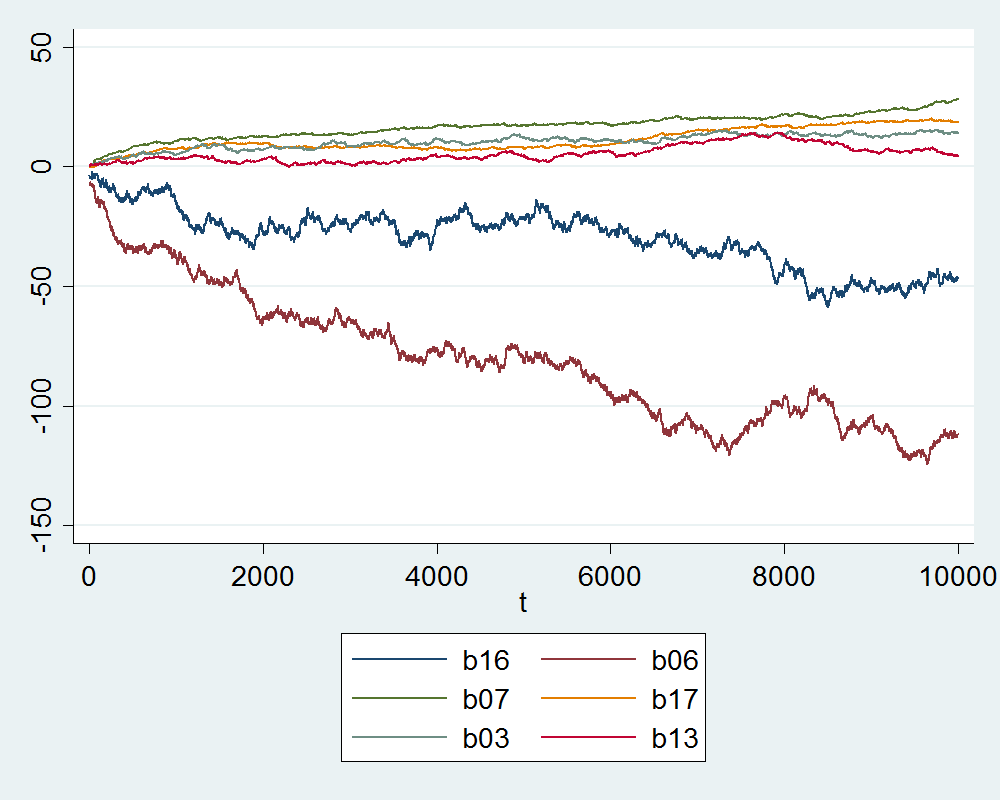

In [17]:
%%stata -gr
tsline b16 b06 b07 b17 b03 b13

## What is to be done? 

Well, there are a couple of things to be done. One is to just put priors on the parameters that restrict them to be a certain size. This is a bit unattractive without first knowing exactly why the problem is occurring, so I'm going to try and figure that out first. 